In [1]:
import os
os.environ["JAVA_HOME"] = "C:\\jdk-22.0.2"
os.environ["SPARK_HOME"] = "C:\\spark-3.5.2-bin-hadoop3\\spark-3.5.2-bin-hadoop3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_PYTHON"] = "python"

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, lit, regexp_extract
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np

In [3]:
spark = SparkSession.builder.appName('Pyspark_Loan').getOrCreate()

In [4]:
df = spark.read.csv('C:\\01-FaculdadeSemestreAtual\\Processamento_de_Dados_Massivos\\Loan_Approval\\train.csv',header = 'True',inferSchema='True')
final_test = spark.read.csv('C:\\01-FaculdadeSemestreAtual\\Processamento_de_Dados_Massivos\\Loan_Approval\\test.csv',header = 'True',inferSchema='True')

In [5]:
df.show(5)

+---+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-------------------+-------------------------+--------------------------+-----------+
| id|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|loan_status|
+---+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-------------------+-------------------------+--------------------------+-----------+
|  0|        37|        35000|                 RENT|              0.0|  EDUCATION|         B|     6000|        11.49|               0.17|                        N|                        14|          0|
|  1|        22|        56000|                  OWN|              6.0|    MEDICAL|         C|     4000|        13.35|               0.07|                        N|                         

In [6]:
df.count()

58645

In [7]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- person_age: integer (nullable = true)
 |-- person_income: integer (nullable = true)
 |-- person_home_ownership: string (nullable = true)
 |-- person_emp_length: double (nullable = true)
 |-- loan_intent: string (nullable = true)
 |-- loan_grade: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- loan_int_rate: double (nullable = true)
 |-- loan_percent_income: double (nullable = true)
 |-- cb_person_default_on_file: string (nullable = true)
 |-- cb_person_cred_hist_length: integer (nullable = true)
 |-- loan_status: integer (nullable = true)



In [8]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-------------------+-------------------------+--------------------------+-----------+
| id|person_age|person_income|person_home_ownership|person_emp_length|loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|loan_status|
+---+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-------------------+-------------------------+--------------------------+-----------+
|  0|         0|            0|                    0|                0|          0|         0|        0|            0|                  0|                        0|                         0|          0|
+---+----------+-------------+---------------------+-----------------+-----------+----------+---------+-------------+-------------------+-------------------------+-------------------------

In [9]:
df.limit(100).toPandas().sample(10)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
17,17,29,60000,OWN,13.0,MEDICAL,A,15000,6.62,0.25,N,9,0
82,82,24,75000,RENT,3.0,PERSONAL,B,15000,11.49,0.20,N,2,0
40,40,30,120000,MORTGAGE,4.0,EDUCATION,A,4000,7.14,0.03,N,10,0
15,15,29,33000,OWN,8.0,MEDICAL,A,7300,8.90,0.23,N,8,0
9,9,35,110000,MORTGAGE,0.0,DEBTCONSOLIDATION,C,15000,12.98,0.14,Y,6,0
88,88,23,110000,MORTGAGE,7.0,DEBTCONSOLIDATION,B,6000,11.71,0.05,N,3,0
87,87,31,30000,RENT,0.0,VENTURE,A,12000,8.94,0.40,N,6,1
99,99,27,70000,RENT,0.0,EDUCATION,B,15000,10.99,0.21,N,7,0
61,61,28,60000,RENT,2.0,VENTURE,A,5500,5.42,0.09,N,5,0
86,86,48,112000,MORTGAGE,21.0,MEDICAL,A,5000,7.90,0.04,N,17,0


In [10]:
df.groupby('loan_intent').count().show()

+-----------------+-----+
|      loan_intent|count|
+-----------------+-----+
|DEBTCONSOLIDATION| 9133|
|          VENTURE|10011|
|         PERSONAL|10016|
|        EDUCATION|12271|
|  HOMEIMPROVEMENT| 6280|
|          MEDICAL|10934|
+-----------------+-----+



In [11]:
df.groupby('loan_grade').count().show()

+----------+-----+
|loan_grade|count|
+----------+-----+
|         F|  149|
|         E| 1009|
|         B|20400|
|         D| 5034|
|         C|11036|
|         A|20984|
|         G|   33|
+----------+-----+



In [12]:
df.groupBy('loan_status').count().show()

+-----------+-----+
|loan_status|count|
+-----------+-----+
|          1| 8350|
|          0|50295|
+-----------+-----+



In [13]:
# Definir as colunas categóricas se deseja codificar
categorical_columns = ["loan_grade", "person_home_ownership", "loan_intent", 'cb_person_default_on_file']

# Criar os indexadores
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index") for column in categorical_columns]

# Criar os OneHotEncoders
encoders = [OneHotEncoder(inputCol=column + "_index", outputCol=column + "_onehot") for column in ["person_home_ownership", "loan_intent"]]

# Criar um pipeline que aplica primeiro os indexadores e depois os encoders
pipeline = Pipeline(stages=indexers + encoders)

# Ajustar e transformar o DataFrame com o pipeline
df_encoded = pipeline.fit(df).transform(df)

# Mostrar o resultado
df_encoded.show()


+---+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-------------------+-------------------------+--------------------------+-----------+----------------+---------------------------+-----------------+-------------------------------+----------------------------+------------------+
| id|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|loan_status|loan_grade_index|person_home_ownership_index|loan_intent_index|cb_person_default_on_file_index|person_home_ownership_onehot|loan_intent_onehot|
+---+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-------------------+-------------------------+--------------------------+-----------+----------------+---------------------------+-----------------+-------------------------

In [14]:
# Agora, são elimindas as colunas que não são úteis
df_encoded = df_encoded.drop("id","person_home_ownership","loan_intent","loan_grade","cb_person_default_on_file", 'person_home_ownership_index', 'loan_intent_index')

feature_columns = df_encoded.columns

# retirando a variácvel a ser predita
feature_columns.remove('loan_status')

# Antes de modelar, todas as colunas são colocadas em único vetor
feature = VectorAssembler(inputCols = feature_columns,outputCol="features")
feature_vector=feature.transform(df_encoded)
feature_vector.limit(3).toPandas()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,loan_grade_index,cb_person_default_on_file_index,person_home_ownership_onehot,loan_intent_onehot,features
0,37,35000,0.0,6000,11.49,0.17,14,0,1.0,0.0,"(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(37.0, 35000.0, 0.0, 6000.0, 11.49, 0.17, 14.0..."
1,22,56000,6.0,4000,13.35,0.07,2,0,2.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(22.0, 56000.0, 6.0, 4000.0, 13.35, 0.07, 2.0,..."
2,29,28800,8.0,6000,8.90,0.21,10,0,0.0,0.0,"(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0, 0.0, 0.0)","(29.0, 28800.0, 8.0, 6000.0, 8.9, 0.21, 10.0, ..."


In [15]:
# Seleciona as colunas usadas no treinamento
loan_df = feature_vector.select(['features','loan_status'])
# Split the dataset to train_df and test_df
train_df,test_df = loan_df.randomSplit([0.7,0.3])

In [16]:
loan_df.groupBy('loan_status').count().show()

+-----------+-----+
|loan_status|count|
+-----------+-----+
|          1| 8350|
|          0|50295|
+-----------+-----+



In [17]:
test_df.groupBy('loan_status').count().show()

+-----------+-----+
|loan_status|count|
+-----------+-----+
|          1| 2557|
|          0|15125|
+-----------+-----+



In [18]:
train_df.groupBy('loan_status').count().show()

+-----------+-----+
|loan_status|count|
+-----------+-----+
|          1| 5793|
|          0|35170|
+-----------+-----+



In [19]:
lr = LogisticRegression(labelCol="loan_status")

model_lr = lr.fit(train_df)
model_predictions= model_lr.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='loan_status',metricName='accuracy').evaluate(model_predictions))
print('Precision: ', MulticlassClassificationEvaluator(labelCol='loan_status',metricName='weightedPrecision').evaluate(model_predictions))
print('Recall: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='weightedRecall').evaluate(model_predictions))
print('F1-Score: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='f1').evaluate(model_predictions))

Accuracy:  0.9001244203144441
Precision:  0.8910225246897211
Recall:  0.9001244203144441
F1-Score:  0.890251854319285


In [20]:
# Ajustando os hiperparâmetros
lr = LogisticRegression(labelCol="loan_status")

# Definindo as faixas dos hiperparâmtros para o Grid Search
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

from pyspark.ml.tuning import CrossValidator

# Etapa de cross-validation usando 5 folds
cv = CrossValidator( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='loan_status')
                           ,numFolds=5)
model_lr_h = cv.fit(train_df)
model_predictions= model_lr_h.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='loan_status',metricName='accuracy').evaluate(model_predictions))
print('Precision: ', MulticlassClassificationEvaluator(labelCol='loan_status',metricName='weightedPrecision').evaluate(model_predictions))
print('Recall: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='weightedRecall').evaluate(model_predictions))
print('F1-Score: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='f1').evaluate(model_predictions))

Accuracy:  0.8984277796629341
Precision:  0.890280924651643
Recall:  0.8984277796629341
F1-Score:  0.883950386531577


In [21]:
rf = RandomForestClassifier(labelCol='loan_status')

model_rf = rf.fit(train_df)
model_predictions= model_rf.transform(test_df)


print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='loan_status',metricName='accuracy').evaluate(model_predictions))
print('Precision: ', MulticlassClassificationEvaluator(labelCol='loan_status',metricName='weightedPrecision').evaluate(model_predictions))
print('Recall: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='weightedRecall').evaluate(model_predictions))
print('F1-Score: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='f1').evaluate(model_predictions))

Accuracy:  0.939203709987558
Precision:  0.9398925394517854
Recall:  0.939203709987558
F1-Score:  0.9334721650639556


In [22]:
# Ajustando os hiperparâmetros (demora mais...)
rf = RandomForestClassifier(labelCol='loan_status')
paramGrid = ParamGridBuilder()\
                                .addGrid(rf.maxDepth, [5, 10, 20]) \
                                .addGrid(rf.maxBins, [20, 32, 50]) \
                                .addGrid(rf.numTrees, [20, 40, 60 ]) \
                                .addGrid(rf.impurity, ["gini", "entropy"]) \
                                .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
                                .build()


tvs = TrainValidationSplit(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(labelCol='loan_status'),
    trainRatio=0.8
)

model_rf_h = tvs.fit(train_df)
model_predictions= model_rf_h.transform(test_df)


print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='loan_status',metricName='accuracy').evaluate(model_predictions))
print('Precision: ', MulticlassClassificationEvaluator(labelCol='loan_status',metricName='weightedPrecision').evaluate(model_predictions))
print('Recall: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='weightedRecall').evaluate(model_predictions))
print('F1-Score: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='f1').evaluate(model_predictions))

Accuracy:  0.948195905440561
Precision:  0.9474567407952067
Recall:  0.9481959054405611
F1-Score:  0.9449691910477751


In [23]:
from pyspark.ml.classification import GBTClassifier

# Gradient Boosting Classifier
gbt = GBTClassifier(labelCol='loan_status')

# Treinando o modelo
model_gbt = gbt.fit(train_df)

# Fazendo previsões
model_predictions_gbt = model_gbt.transform(test_df)

# Avaliação
print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='accuracy').evaluate(model_predictions_gbt))
print('Precision: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='weightedPrecision').evaluate(model_predictions_gbt))
print('Recall: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='weightedRecall').evaluate(model_predictions_gbt))
print('F1-Score: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='f1').evaluate(model_predictions_gbt))

Accuracy:  0.9472910304264224
Precision:  0.9471725676888005
Recall:  0.9472910304264224
F1-Score:  0.9435236302311122


In [24]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Gradient Boosting Classifier
gbt = GBTClassifier(labelCol='loan_status')

# Definindo a grade de hiperparâmetros
paramGrid_gbt = ParamGridBuilder()\
                                .addGrid(gbt.maxDepth, [5, 10, 20]) \
                                .addGrid(gbt.maxIter, [10, 20, 30]) \
                                .addGrid(gbt.stepSize, [0.01, 0.1, 0.3]) \
                                .build()

# Configuração de TrainValidationSplit
tvs_gbt = TrainValidationSplit(
    estimator=gbt,
    estimatorParamMaps=paramGrid_gbt,
    evaluator=MulticlassClassificationEvaluator(labelCol='loan_status'),
    trainRatio=0.8
)

# Ajustando o modelo
model_gbt_h = tvs_gbt.fit(train_df)

# Fazendo previsões
model_predictions_gbt_h = model_gbt_h.transform(test_df)

# Avaliação
print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='accuracy').evaluate(model_predictions_gbt_h))
print('Precision: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='weightedPrecision').evaluate(model_predictions_gbt_h))
print('Recall: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='weightedRecall').evaluate(model_predictions_gbt_h))
print('F1-Score: ', MulticlassClassificationEvaluator(labelCol='loan_status', metricName='f1').evaluate(model_predictions_gbt_h))

Accuracy:  0.9466689288542021
Precision:  0.9461628715438987
Recall:  0.9466689288542021
F1-Score:  0.9430247517498705


# Model Fit

In [25]:
df_submission=final_test.drop('id')
df_submission_encoded = pipeline.fit(final_test).transform(final_test)

# Mostrar o resultado
df_submission_encoded.show()

+-----+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-------------------+-------------------------+--------------------------+----------------+---------------------------+-----------------+-------------------------------+----------------------------+------------------+
|   id|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_percent_income|cb_person_default_on_file|cb_person_cred_hist_length|loan_grade_index|person_home_ownership_index|loan_intent_index|cb_person_default_on_file_index|person_home_ownership_onehot|loan_intent_onehot|
+-----+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-------------------+-------------------------+--------------------------+----------------+---------------------------+-----------------+-------------------------------+-----------------------

In [26]:
df_submission_encoded = df_submission_encoded.drop(
 'person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file',
 'person_home_ownership_index',
 'loan_intent_index')

In [27]:
# Antes de modelar, todas as colunas são colocadas em único vetor
feature_columns = df_submission_encoded.columns

feature = VectorAssembler(inputCols = feature_columns,outputCol="features")
feature_vector=feature.transform(df_submission_encoded)
feature_vector.limit(3).toPandas()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_grade_index,cb_person_default_on_file_index,person_home_ownership_onehot,loan_intent_onehot,features
0,58645,23,69000,3.0,25000,15.76,0.36,2,5.0,0.0,"(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0)","(58645.0, 23.0, 69000.0, 3.0, 25000.0, 15.76, ..."
1,58646,26,96000,6.0,10000,12.68,0.10,4,2.0,1.0,"(0.0, 1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0)","[58646.0, 26.0, 96000.0, 6.0, 10000.0, 12.68, ..."
2,58647,26,30000,5.0,4000,17.19,0.13,2,4.0,1.0,"(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0)","[58647.0, 26.0, 30000.0, 5.0, 4000.0, 17.19, 0..."


# Kagle submission

In [28]:
model_predictions= model_rf.transform(feature_vector.select('features'))

In [29]:
submission = feature_vector.select('id', 'features').join(model_predictions, 'features').select('id', 'probability')

In [30]:
submission.show()

+-----+--------------------+
|   id|         probability|
+-----+--------------------+
|58645|[0.73867055662870...|
|58646|[0.27195435876761...|
|58647|[0.39049311996057...|
|58648|[0.71935816274075...|
|58649|[0.34921675908098...|
|58650|[0.65557294339025...|
|58651|[0.63528719122963...|
|58652|[0.68410761180946...|
|58653|[0.32340115957086...|
|58654|[0.35923010538493...|
|58655|[0.71642473452175...|
|58656|[0.68410761180946...|
|58657|[0.33034617323206...|
|58658|[0.68777506154895...|
|58659|[0.73790135900483...|
|58660|[0.61889465485729...|
|58661|[0.58589517351087...|
|58662|[0.55150463965219...|
|58663|[0.71935816274075...|
|58664|[0.58459812615144...|
+-----+--------------------+
only showing top 20 rows



In [31]:
# Preparação do arquivo de submissão conforme orientado

from pyspark.ml.functions import vector_to_array

kaggle_submission = submission.withColumn("loan_status", vector_to_array("probability")[1]).drop('probability')


In [32]:
kaggle_submission.show()

+-----+-------------------+
|   id|        loan_status|
+-----+-------------------+
|58645| 0.2613294433712968|
|58646| 0.7280456412323892|
|58647| 0.6095068800394275|
|58648| 0.2806418372592425|
|58649| 0.6507832409190116|
|58650|0.34442705660974804|
|58651|0.36471280877036877|
|58652|0.31589238819053506|
|58653| 0.6765988404291327|
|58654|  0.640769894615067|
|58655|0.28357526547824774|
|58656|0.31589238819053506|
|58657| 0.6696538267679306|
|58658| 0.3122249384510497|
|58659|0.26209864099516755|
|58660|0.38110534514270966|
|58661| 0.4141048264891203|
|58662| 0.4484953603478054|
|58663| 0.2806418372592425|
|58664| 0.4154018738485556|
+-----+-------------------+
only showing top 20 rows



In [33]:
kaggle_submission.toPandas().to_csv('submission_rf.csv', index=False)

## Tentei diversos modelos mas não consegui uma precisão maior que 60%

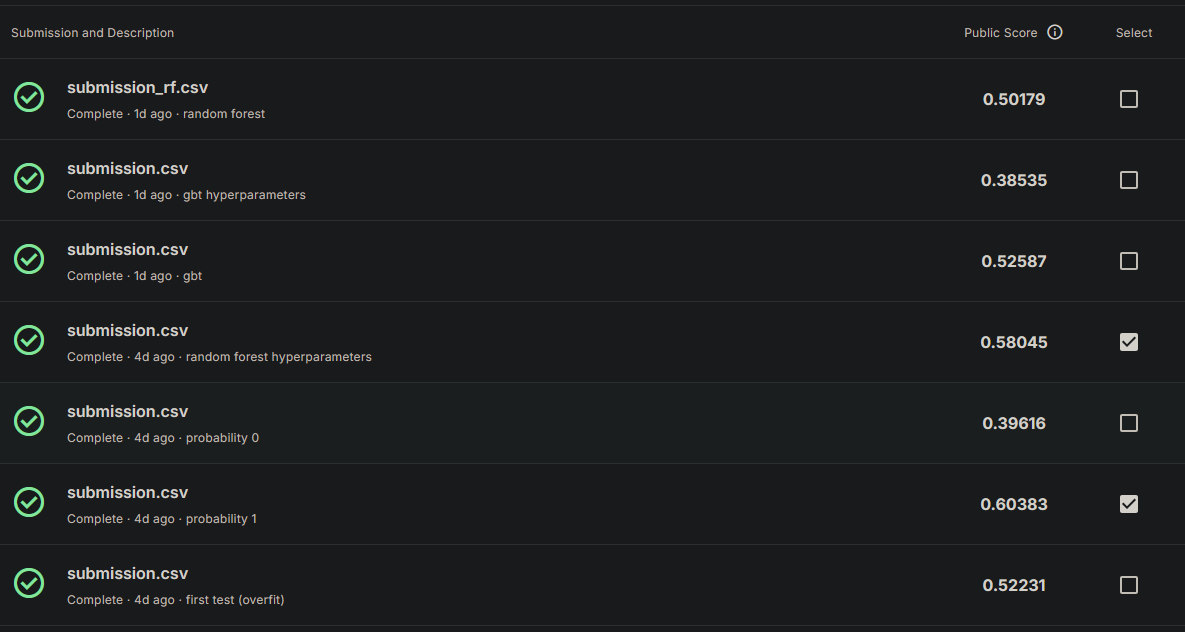